In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')
import datetime
import time

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd

# Main imports
import econml
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt

# EconML imports
from econml.dr import LinearDRLearner
from econml.iv.nnet import DeepIV
import keras
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference

import warnings
warnings.simplefilter('ignore')

In [2]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

# DGP constants
np.random.seed(1234)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
# ORF parameters and test data
subsample_ratio = 0.4
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))


In [3]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(W.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

outcome_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(W.shape[1]+1,)),
                                  keras.layers.Dropout(0.17),
                                  keras.layers.Dense(64, activation='relu'),
                                  keras.layers.Dropout(0.17),
                                  keras.layers.Dense(32, activation='relu'),
                                  keras.layers.Dropout(0.17),
                                  keras.layers.Dense(1)])

from keras.optimizers import Adagrad


keras_fit_options_1 = {"epochs": 200,
                      "validation_split": 0.20,
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
                      }
keras_fit_options_2 = {"epochs": 200,
                      "validation_split": 0.20,
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
                      }

deepIvEst = DeepIV(n_components = 15, 
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z,x])), 
                   h = lambda t, x : outcome_model(keras.layers.concatenate([t,x])),  
                   n_samples = 2, 
                   use_upper_bound_loss = True, 
                   n_gradient_samples = 0, 
                   optimizer= keras.optimizers.Adagrad(learning_rate=0.0009,),  
                   first_stage_options = keras_fit_options_2, 
                   second_stage_options = keras_fit_options_1
                   ) 

Epoch 1/200
25/25 [==============================] - 1s 16ms/step - loss: 0.2752 - val_loss: 0.2520
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2691 - val_loss: 0.2480
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2652 - val_loss: 0.2446
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2600 - val_loss: 0.2418
Epoch 5/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2607 - val_loss: 0.2392
Epoch 6/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2547 - val_loss: 0.2369
Epoch 7/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2533 - val_loss: 0.2348
Epoch 8/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2504 - val_loss: 0.2329
Epoch 9/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2480 - val_loss: 0.2312
Epoch 10/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2478 - val_loss: 0.2295
Epoch 11

25/25 [==============================] - 0s 4ms/step - loss: 0.1806 - val_loss: 0.1703
Epoch 84/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1819 - val_loss: 0.1697
Epoch 85/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1797 - val_loss: 0.1692
Epoch 86/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1788 - val_loss: 0.1686
Epoch 87/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1804 - val_loss: 0.1680
Epoch 88/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1781 - val_loss: 0.1675
Epoch 89/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1780 - val_loss: 0.1669
Epoch 90/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1778 - val_loss: 0.1663
Epoch 91/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1761 - val_loss: 0.1658
Epoch 92/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1770 - val_loss: 0.1652
Epoch 93/200


25/25 [==============================] - 0s 4ms/step - loss: 0.1355 - val_loss: 0.1288
Epoch 165/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1357 - val_loss: 0.1283
Epoch 166/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1358 - val_loss: 0.1278
Epoch 167/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1365 - val_loss: 0.1274
Epoch 168/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1361 - val_loss: 0.1269
Epoch 169/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1336 - val_loss: 0.1264
Epoch 170/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1338 - val_loss: 0.1259
Epoch 171/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1345 - val_loss: 0.1254
Epoch 172/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1335 - val_loss: 0.1250
Epoch 173/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1332 - val_loss: 0.1245
Epoc

32/32 [==============================] - 0s 1ms/step


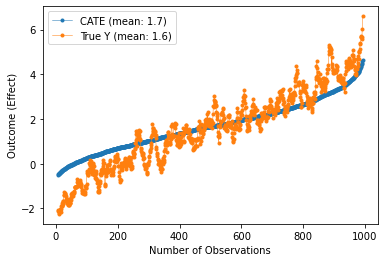

In [4]:
deepIvEst.fit(Y=Y,T=T,X=W,Z=X)

y_pred_per = deepIvEst.predict(T, W)
te_df_per = pd.DataFrame(y_pred_per, columns=['cate'])
te_df_per['true y']=Y
te_df_per.sort_values('cate', inplace=True, ascending=True)
te_df_per.reset_index(inplace=True, drop=True)
z_per = te_df_per.rolling(window=15, center=True).mean()

cate_mean=np.mean(te_df_per['cate'])
y_mean=np.mean(te_df_per['true y'])

plt.plot(z_per['cate'],
            marker='.', linestyle='-', 
            linewidth=0.5, 
            label='CATE (mean: '+str(round(cate_mean,2))+')', 
            )
plt.plot(z_per['true y'],
        marker='.', linestyle='-', 
            linewidth=0.5, 
            label='True Y (mean: '+str(round(y_mean,2))+')', 
            )
plt.ylabel('Outcome (Effect)')
plt.xlabel('Number of Observations')
plt.legend()
plt.show()

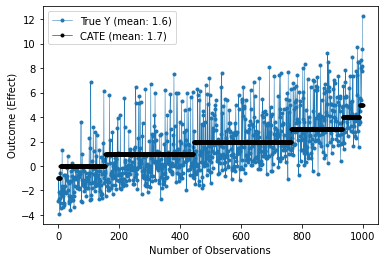

In [5]:
te_df_per = pd.DataFrame(y_pred_per, columns=['cate'])
te_df_per['true y']=Y
te_df_per.sort_values('cate', inplace=True, ascending=True)
te_df_per.reset_index(inplace=True, drop=True)
z_per = te_df_per.rolling(window=15, center=True).mean()

cate_mean=np.mean(np.round(te_df_per['cate'],0))
y_mean=np.mean(te_df_per['true y'])


plt.plot(te_df_per['true y'],
        marker='.', linestyle='-', 
            linewidth=0.5, 
            label='True Y (mean: '+str(round(y_mean,2))+')', 
            )

plt.plot(np.round(te_df_per['cate'],0),
            marker='.', linestyle='-', 
            linewidth=0.5, 
            label='CATE (mean: '+str(round(cate_mean,2))+')',color='black' 
            )
plt.ylabel('Outcome (Effect)')
plt.xlabel('Number of Observations')
plt.legend()
plt.show()

In [6]:
subsample_ratio=.3
lambda_reg = np.sqrt(np.log(W.shape[1]) / (10 * subsample_ratio * W.shape[0]))

In [7]:
est = DROrthoForest(
    n_trees=200, min_leaf_size=10,
    max_depth=30, subsample_ratio=subsample_ratio,
    propensity_model = LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
    model_Y = Lasso(alpha=lambda_reg),
    propensity_model_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
    model_Y_final=WeightedLasso(alpha=lambda_reg)
)

In [8]:
est.fit(Y, T, X=X, W=W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


In [9]:
# Calculate treatment effects for the default treatment points T0=0 and T1=1
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.6s finished


In [10]:
# Calculate default (95%) confidence intervals for the default treatment points T0=0 and T1=1
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


In [11]:
est2 = CausalForestDML(model_y=Lasso(alpha=lambda_reg),
                       model_t=LogisticRegression(C=1/(X.shape[0]*lambda_reg)),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50, max_samples=subsample_ratio/2,
                       discrete_treatment=True,
                       random_state=123)
est2.fit(Y, T, X=X, W=W, cache_values=True)
treatment_effects2 = est2.effect(X_test)
te_lower2, te_upper2 = est2.effect_interval(X_test)

In [12]:
est2.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate               
================================================================
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
     3.102        0.18 17.249    0.0          2.75         3.455
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    1.717           0.942           6.649
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       1.726          0.834          6.698
        Doubly Robust ATE on Training Data Results       
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATE          3.153  0.081 38.825    0.0    2.994    3.312
     Doubly Robust ATT(T=0) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          3.097  0.095 32.504    0.0    2.911    3.284
     Doubly Robust ATT(T=1) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          3.211  0.133 24.147    0.0     2.95    3.472
---------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

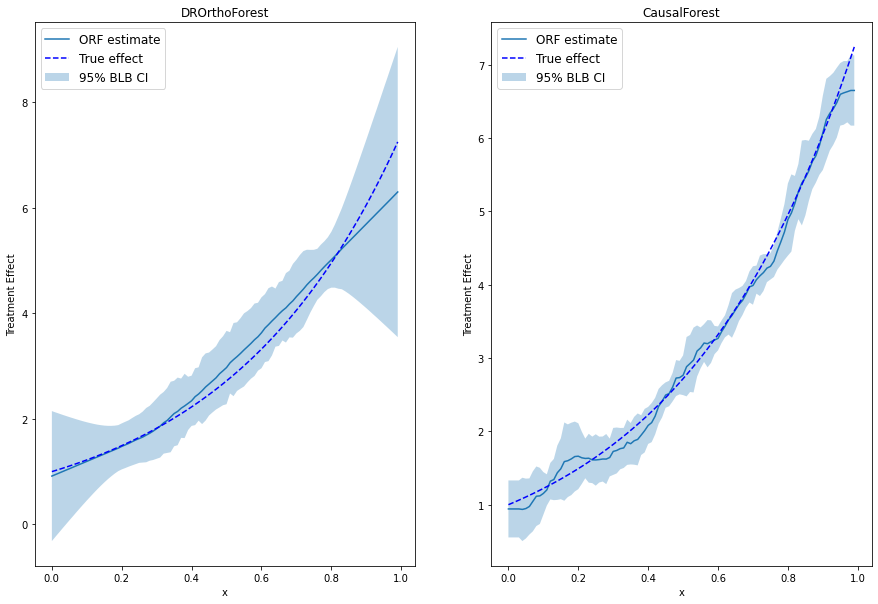

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title("DROrthoForest")
plt.plot(X_test, treatment_effects, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower, te_upper, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend(loc=2,prop={'size': 12})
plt.subplot(1, 2, 2)
plt.title("CausalForest")
plt.plot(X_test, treatment_effects2, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower2, te_upper2, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend(loc=2,prop={'size': 12})
plt.show()

In [14]:
ATE_for_cf=np.mean(expected_te)
ATE_for_cf

In [15]:
est = CausalForestDML(cv=2,
                      criterion='mse', n_estimators=400,
                      min_var_fraction_leaf=0.1,
                      min_var_leaf_on_val=True,
                      verbose=0, discrete_treatment=False,
                      n_jobs=-1, random_state=123)
%time est.fit(Y, T, X=X, W=W)

CPU times: total: 3.03 s
Wall time: 855 ms


In [16]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

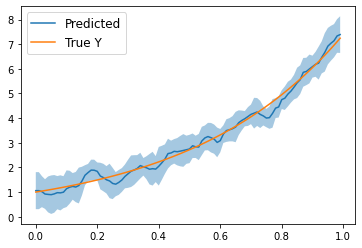

In [17]:
plt.plot(X_test[:, 0], point,label='Predicted')
plt.fill_between(X_test[:,0], lb, ub, alpha=.4)
plt.plot(X_test[:, 0],expected_te,label='True Y')
plt.legend(loc=2,prop={'size': 12})
plt.show()

In [18]:
res.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.058,0.292,3.626,0.000,0.486,1.629
1,1.058,0.292,3.626,0.000,0.486,1.629
2,1.016,0.244,4.162,0.000,0.538,1.495
3,0.920,0.233,3.944,0.000,0.463,1.377
4,0.905,0.283,3.201,0.001,0.351,1.459
...,...,...,...,...,...,...
95,6.920,0.287,24.075,0.000,6.356,7.483
96,7.039,0.275,25.582,0.000,6.500,7.578
97,7.140,0.262,27.254,0.000,6.626,7.653


In [19]:
res = est.effect_inference(X_test,
                           T0=np.zeros((X_test.shape[0],1)),
                           T1=np.ones((X_test.shape[0],1)))
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

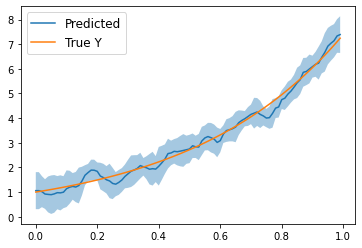

In [20]:
plt.plot(X_test[:, 0], point,label='Predicted')
plt.fill_between(X_test[:,0], lb, ub, alpha=.4)
plt.plot(X_test[:, 0],expected_te,label='True Y')
plt.legend(loc=2,prop={'size': 12})
plt.show()